In [1]:
import keras
import numpy as np
#!brew install hdf5
#!pip3 install tables
import tables
from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [2]:
features = ['track_ptrel',     
          'track_erel',     
          'track_phirel',     
          'track_etarel',     
          'track_deltaR',
          'track_drminsv',     
          'track_drsubjet1',     
          'track_drsubjet2',
          'track_dz',     
          'track_dzsig',     
          'track_dxy',     
          'track_dxysig',     
          'track_normchi2',     
          'track_quality',     
          'track_dptdpt',     
          'track_detadeta',     
          'track_dphidphi',     
          'track_dxydxy',     
          'track_dzdz',     
          'track_dxydz',     
          'track_dphidxy',     
          'track_dlambdadz',     
          'trackBTag_EtaRel',     
          'trackBTag_PtRatio',     
          'trackBTag_PParRatio',     
          'trackBTag_Sip2dVal',     
          'trackBTag_Sip2dSig',     
          'trackBTag_Sip3dVal',     
          'trackBTag_Sip3dSig',     
          'trackBTag_JetDistVal']

spectators = ['track_mass', 'track_pt']

labels = ['fj_isQCD*sample_isQCD',
          'fj_isH*fj_isBB']

nfeatures = len(features)
nspectators = len(spectators)
nlabels = len(labels)

In [3]:
def get_features_labels(file_name, remove_mass_pt_window=True):
    # load file
    h5file = tables.open_file(file_name, 'r')
    njets = getattr(h5file.root,features[0]).shape[0]

    # allocate arrays
    feature_array = np.zeros((njets,nfeatures))
    #print("feature_array: ", feature_array.shape)
    spec_array = np.zeros((njets,nspectators))
    #print("spec_array: ", feature_array.shape)
    label_array = np.zeros((njets,nlabels))
    #print("label_array: ", feature_array.shape)

    # load feature arrays
    for (i, feat) in enumerate(features):
        #print(feature_array.shape)
        #print(getattr(h5file.root,feat))
        feature_array[:,i] = getattr(h5file.root,feat)[:,i]
        

    # load spectator arrays
    for (i, spec) in enumerate(spectators):
        spec_array[:,i] = getattr(h5file.root,spec)[:, i]

    # load labels arrays
    for (i, label) in enumerate(labels):
        prods = label.split('*')
        prod0 = prods[0]
        prod1 = prods[1]
        fact0 = getattr(h5file.root,prod0)[:]
        fact1 = getattr(h5file.root,prod1)[:]
        label_array[:,i] = np.multiply(fact0,fact1)

    # remove samples outside mass/pT window
    if remove_mass_pt_window:
        feature_array = feature_array[(spec_array[:,0] > 40) & (spec_array[:,0] < 200) & (spec_array[:,1] > 300) & (spec_array[:,1] < 2000)]
        label_array = label_array[(spec_array[:,0] > 40) & (spec_array[:,0] < 200) & (spec_array[:,1] > 300) & (spec_array[:,1] < 2000)]

    feature_array = feature_array[np.sum(label_array,axis=1)==1]
    label_array = label_array[np.sum(label_array,axis=1)==1]
    #print("feature_array: ", feature_array.shape)

    h5file.close()
    return feature_array, label_array

In [4]:
import os.path
if not os.path.isfile('ntuple_merged_10.h5'): 
    !xrdcp root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/train/ntuple_merged_10.h5 .

# load training file
feature_array, label_array = get_features_labels('ntuple_merged_10.h5', remove_mass_pt_window=False)

In [5]:
# define dense keras model
inputs = Input(shape=(nfeatures,), name = 'input')  
x = BatchNormalization(name='bn_1')(inputs)
x = Dense(64, name = 'dense_1', activation='relu')(x)
x = Dense(32, name = 'dense_2', activation='relu')(x)
x = Dense(32, name = 'dense_3', activation='relu')(x)
outputs = Dense(nlabels, name = 'output', activation='softmax')(x)
keras_model = Model(inputs=inputs, outputs=outputs)
keras_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(keras_model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 30)             │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,306 (20.73 KB)

 Trainable params: 5,246 (20.49 KB)

 Non-trainable params: 60 (240.00 B)

None


In [6]:
# define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = ModelCheckpoint('keras_model_best.keras', monitor='val_loss', save_best_only=True)
callbacks = [early_stopping, model_checkpoint]

# fit keras model
keras_model.fit(feature_array, label_array, batch_size=1024, 
                epochs=100, validation_split=0.2, shuffle=False,
                callbacks = callbacks)



Epoch 1/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8635 - loss: 0.4174 - val_accuracy: 0.8697 - val_loss: 0.3680
Epoch 2/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8687 - loss: 0.3497 - val_accuracy: 0.8697 - val_loss: 0.3534
Epoch 3/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8687 - loss: 0.3442 - val_accuracy: 0.8698 - val_loss: 0.3427
Epoch 4/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8693 - loss: 0.3410 - val_accuracy: 0.8702 - val_loss: 0.3383
Epoch 5/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8700 - loss: 0.3385 - val_accuracy: 0.8707 - val_loss: 0.3364
Epoch 6/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8705 - loss: 0.3360 - val_accuracy: 0.8712 - val_loss: 0.3350
Epoch 7/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8710 - loss: 0.3339 - val_accuracy: 0.8713 - val_loss: 0.3339
Epoch 8/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8715 - loss: 0.3320 - val_accu

In [7]:
# copy testing file if it doesn't exist
import os.path
if not os.path.isfile('ntuple_merged_0.h5'): 
    !xrdcp root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/test/ntuple_merged_0.h5 .
        
# load testing file
feature_array_test, label_array_test = get_features_labels('ntuple_merged_0.h5', remove_mass_pt_window=False)
#feature_array, label_array = get_features_labels('ntuple_merged_10.h5', remove_mass_pt_window=False)

5873/5873 ━━━━━━━━━━━━━━━━━━━━ 1s 238us/step


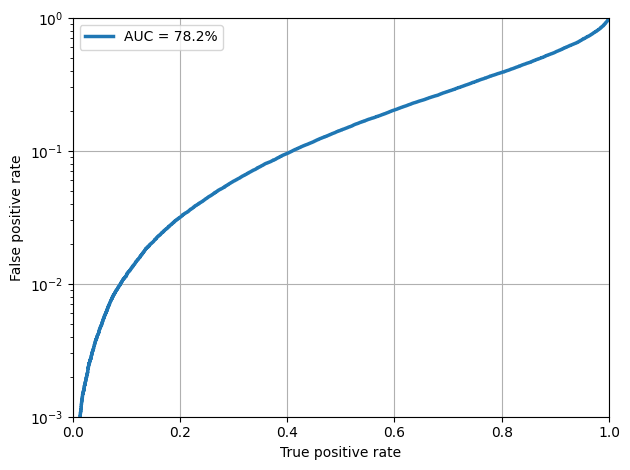

In [8]:
keras_model.load_weights('keras_model_best.keras')

# run model inference on test data set
predict_array_test = keras_model.predict(feature_array_test)

# create ROC curve
fpr, tpr, threshold = roc_curve(label_array_test[:,1], predict_array_test[:,1])
    
# plot ROC curve
plt.figure()
plt.plot(tpr, fpr, lw=2.5, label="AUC = {:.1f}%".format(auc(fpr,tpr)*100))
plt.xlabel(r'True positive rate')
plt.ylabel(r'False positive rate')
plt.semilogy()
plt.ylim(0.001,1)
plt.xlim(0,1)
plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('ROC.png')
plt.savefig('ROC.pdf')


